## Task description
The goal of this subtask is to develop our own model and use it to learn the sine function on the interval . Discretize $[0, 2\pi]$
the interval with a suitable number of points (of your choice) and use the values of the sine function at these discretization points as labels. Implement a Quantum Machine Learning model which reproduces the values of the sine function.

## Building a QML model from scratch

Typically we will use a hybrid system, where parts of the input processing are done on classical computer, next step is to drive a parameterized/variational quantum circuit, optimize and iterate and so on. Below is a rough list of components we need.

* A quantum circuit and associated quantum device
* A data pre-processing unit
* Define a cost function, loss definition
* An optimizer that starts with an initial value for the parameters, and then iterate for better results

## Approximating a Sine Function

Ref [1] shows that we can write a quantum model as a partial Fourier series in the data. For sine wave we would need a single frequency only.

[1 - reference](https://arxiv.org/pdf/2008.08605) - The effect of data encoding on the expressive power of variational quantum machine learning models, Schuld et al.

## Common steps

Here we define a `loss` function, `cost` function,`optimizer` and a few miscellaneous helper functions, these are fairly basic and classical components. We create these and first and then we explore our quantum circuit(s) afterwards.

In [4]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

We try to keep this generic code as flexible as possible to allow for easier exploration and analysis later.

In [5]:
def loss_square(labels_y, predictions):
    loss = 0
    for l,p in zip(labels_y, predictions):
        loss += (l - p) **2
    return loss / len(labels_y)

def cost(params, data, q_circuit, target_y):
    preds = [q_circuit(x, params=params) for x in data]
    return loss_square(labels_y=target_y, predictions=preds)

def train(epochs, 
          x_points, 
          y_points, 
          q_circuit, 
          init_params,
          sgd_stepsize=0.01, 
          batch_size=8, 
          print_freq=10):
    print(f"=== train for {epochs} epochs ===")
    # start with some random weights/params
    params = init_params
    opt = qml.AdamOptimizer(stepsize=sgd_stepsize)
    l_cost = [cost(params=params, 
                data=x_points, 
                target_y=y_points, 
                q_circuit=q_circuit)]

    for ep in range(epochs):
        batch_index = np.random.randint(0, len(x_points), (batch_size,))
        x_batch = x_points[batch_index]
        y_batch = y_points[batch_index]

        # update the weights by one optimizer step
        params, _, _, _ = opt.step(cost, params, x_batch, q_circuit, y_batch)

        c = cost(params, 
                 data=x_points, 
                 target_y=y_points, 
                 q_circuit=q_circuit)
        l_cost.append(c)
        if print_freq != 0 and (ep + 1) % print_freq == 0:
            print(f"Cost at ep[{ep+1:3d}]: {c}")
    return params, l_cost

def data_generate(how_many):
    x = np.linspace(0, 2*np.pi, how_many)
    x.requires_grad = False
    y = np.sin(x)
    return x, y

def visualize_results(X_train, Y_train, X_test, Y_test, Y_test_preds):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.scatter(X_train, Y_train, s=30, c='b', marker="s", label='Train labels')
    ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='ground truth')
    ax1.scatter(X_test,Y_test_preds, s=30, c='k', marker="x", label='Test predicitons')
    plt.xlabel("Inputs")
    plt.ylabel("Outputs")
    plt.title("QML results")
    # plt.grid(axis='y')
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    
    plt.legend(loc='upper right');
    display(plt.show())

def visualize_cost(l_cost):
    plt.plot(range(len(l_cost)), l_cost)
    plt.ylabel("Cost")
    plt.xlabel("Epoch")
    plt.show()


### Quantum Circuit
Here we create a one qubit quantum device (simulator). We define a set of minimal quantum circuits that we plan to explore and compare the results.

In [6]:
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def quantum_circuit1(x, params):
    qml.RX(x, wires=0)
    qml.Rot(params[0], params[1], params[2], wires=0)
    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev)
def quantum_circuit2(x, params):
    p0, p1, p2 = params
    qml.RX(x, wires=0)
    qml.RY(p0, wires=0)
    qml.RZ(p1, wires=0)
    qml.RY(p2, wires=0)
    # expected value along Z
    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev)
def quantum_circuit3(x, params):
    p0, p1, p2 = params
    qml.RX(x, wires=0)
    qml.RZ(p0, wires=0)
    qml.RY(p1, wires=0)
    qml.RZ(p2, wires=0)
    # expected value along Z
    return qml.expval(qml.PauliZ(wires=0))



## Dataset for Training and Test
We generate a few data points for training and a few more for testing. In a typical set up we never mix the training and test data. This way we can be sure that the testing is being performed on a dataset that our model has not seen before.

In [7]:
X, Y = data_generate(5)
X_test, Y_test = data_generate(20)

## Training
We pick a quantum circuit and train it with our training dataset.

In [8]:
qc = quantum_circuit2
params, l_cost = train(epochs=100, 
                       x_points=X, 
                       y_points=Y, 
                       q_circuit=qc, 
                       sgd_stepsize=0.3,
                       init_params=np.array([0.1,0.1, 0.1],requires_grad=True),
                       print_freq=10)

=== train for 100 epochs ===
Cost at ep[ 10]: 0.07220704080794846
Cost at ep[ 20]: 0.011580214149641934
Cost at ep[ 30]: 0.006791661208242603
Cost at ep[ 40]: 0.0018595833540511746
Cost at ep[ 50]: 0.0005984294806630712
Cost at ep[ 60]: 0.0005336545627441756
Cost at ep[ 70]: 3.687097404479733e-05
Cost at ep[ 80]: 1.5938357738596093e-05
Cost at ep[ 90]: 1.5656679174118902e-06
Cost at ep[100]: 1.792228398528789e-06


## First results
Let's check how our circuit performs on unseen test data. We plot the results to get a better idea. As we can see below, our cicruit can predict fairly well.

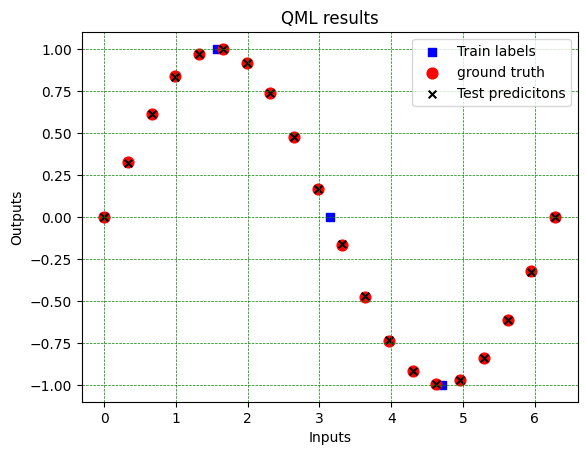

None

In [10]:
Y_test_preds = [qc(x=x, params=params) for x in X_test]
visualize_results(X_train=X, Y_train=Y, X_test=X_test, Y_test=Y_test, Y_test_preds=Y_test_preds)

## Performance / Cost over training epochs

Let's visualize the cost numbers over the iterations, since we start with random initial values for our parameters, it's unsurprising that the cost initially can be high. But then we converge towards a lower cost path.

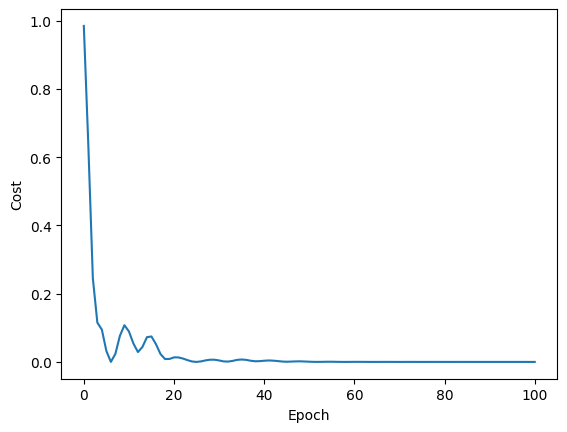

In [11]:
visualize_cost(l_cost)

## Running multiple models
We have created three circuits with minor variations and we want to see if these changes affect the performance and if so, how much. We train and test all of them and collect the results here.

In [12]:
lst_preds = []
lst_costs = []
for qc in [quantum_circuit1, quantum_circuit2, quantum_circuit3]:
    params, l_cost = train(epochs=100, 
                           x_points=X, 
                           y_points=Y, 
                           q_circuit=qc, 
                           sgd_stepsize=0.1,
                           init_params=np.array([0.1,0.1, 0.1],requires_grad=True),
                           print_freq=0)
    Y_test_preds = [qc(x=x, params=params) for x in X_test]
    lst_costs.append(l_cost)
    lst_preds.append(Y_test_preds)
    # visualize_results(X_train=X, Y_train=Y, X_test=X_test, Y_test=Y_test, Y_test_preds=Y_test_preds)
    # visualize_cost(l_cost)

=== train for 100 epochs ===
=== train for 100 epochs ===
=== train for 100 epochs ===


## Compare and contrast
Below, we check the cost/loss trend over iterations for each quantum circuit we have. While initially they start slightly differently, after a few epochs they all converge. This is somewhat expected since our circuits are nearly identical.

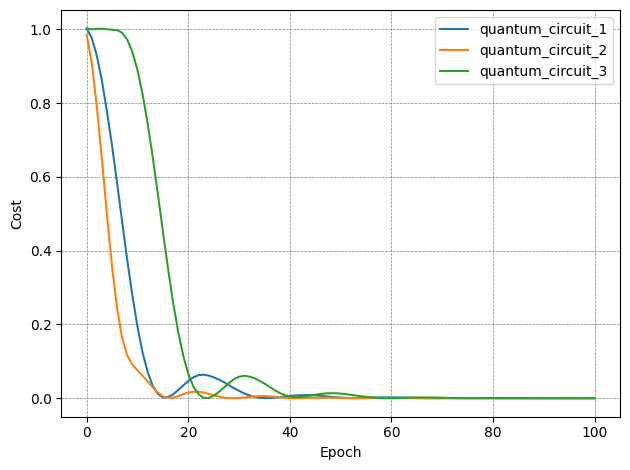

In [14]:
for ii, lc in enumerate(lst_costs):
    plt.plot(range(len(lc)), lc, label=f"quantum_circuit_{ii+1}")
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.tight_layout()
plt.show()